# Machine Learning on IBM i : Real time Customer churn scoring  
### using Scikit Learn, pandas, seaborn and Db2 for i 

Version May 2020 **#Updated: October 2024** 

##### The Dataset

From a telecommunications company. It includes information about:

   - Customers who left within the last month – the column is called Churn

   - Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies

   - Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges

   - Demographic info about customers – gender, age range, and if they have partners and dependents


#### Features Information (non exhaustive) :
- Partner: whether the customer has a partner or not (Yes, No),
- Dependents: whether the customer has dependents or not (Yes, No),
- OnlineBackup: Whether the customer has an online backup or not (Yes, No, No internet service),
- tenure: number of months the customer has stayed with the company,
- MonthlyCharges: the amount charged to the customer monthly,
- TotalCharges: the total amount charged to the customer.
   
Telco dataset is already grouped by customerID so it is difficult to add new features. When working on the churn prediction we usually get a dataset that has one entry per customer session (customer activity in a certain time). Then we could add features like:

    number of sessions before buying something,
    average time per session,
    time difference between sessions (frequent or less frequent customer),
    is a customer only in one country.

Sometimes we even have customer event data, which enables us to find patterns of customer behavior in relation to the outcome (churn).

In [1]:
%pwd

'/home/benoit/firstdemo-scikitlearn-ibmi'

In [2]:
# Dowload the original dataset if necessary
#!wget https://community.watsonanalytics.com/wp-content/uploads/2015/03/WA_Fn-UseC_-Telco-Customer-Churn.csv  --no-check-certificate

# Import packages & libraries 
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
print("sklearn version :", sklearn.__version__)
import pandas as pd
from pandas import Series, DataFrame
#import pandas_profiling
pd.set_option('display.max_rows', None,'display.max_columns', None)

from collections import Counter
from collections import defaultdict
from itertools import combinations

sklearn version : 0.19.1


## 2. Loading Our Dataset from a Relational Database - Db2 for i

In [3]:
import ibm_db_dbi as dbi
# Telco Churn dataset from a CRM datasource - here Db2 for i in CHURN/CUSTCHURN2 7044 records

sql="SELECT * from CHURN.CUSTCHURN3"
pd.set_option('display.max_columns', 30)
try:
    conn = dbi.connect()
    c1 = conn.cursor()
    c1.execute(sql)
    row = c1.fetchone()
    print ("Example:" ,row)
    df_fromdb2 = pd.read_sql(sql, conn)
    conn.close()
    
    df_fromdb2.info()
except Exception as err:
    print('Error'+ str(err))

Example: ('7590-VHVEG', 'Female', Decimal('0'), 'Yes', 'No ', Decimal('1'), 'No ', 'No phone service', 'DSL        ', 'No                 ', 'Yes                ', 'No                 ', 'No                 ', 'No                 ', 'No                 ', 'Month-to-month', 'Yes', 'Electronic check         ', Decimal('29.85'), Decimal('29.85'), 'No ')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CUSTOMERID        7043 non-null   object 
 1   GENDER            7043 non-null   object 
 2   SENIORCITIZEN     7043 non-null   float64
 3   PARTNER           7043 non-null   object 
 4   DEPENDENTS        7043 non-null   object 
 5   TENURE            7043 non-null   float64
 6   PHONESERVICE      7043 non-null   object 
 7   MULTIPLELINES     7043 non-null   object 
 8   INTERNETSERVICE   7043 non-null   object 
 9   ONLINESECURITY    

In [6]:
#display(df_fromdb2)

## 3. Load Dataframe from CSV file (IFS) &Data Visualization

In [7]:
customer_data= pd.read_csv('dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv')
#customer_data=df_fromdb2

In [8]:
# Find correlations method= pearson, kendall, spearman ...
pearsoncorr=customer_data.corr(method='pearson')
pearsoncorr

,SeniorCitizen,tenure,MonthlyCharges
SeniorCitizen,1.000000,0.016567,0.220173
tenure,0.016567,1.000000,0.247900
MonthlyCharges,0.220173,0.247900,1.000000


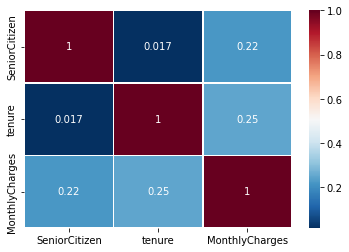

In [9]:
sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

In [10]:
# Describe columns wit>h numerical values
pd.set_option('precision', 3)
customer_data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000,7043.000,7043.000
mean,0.162,32.371,64.762
std,0.369,24.559,30.090
min,0.000,0.000,18.250
25%,0.000,9.000,35.500
50%,0.000,29.000,70.350
75%,0.000,55.000,89.850
max,1.000,72.000,118.750


In [11]:
# After running this cell we will see that we have no missing values
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [12]:
# Drop customerID column
customer_data = customer_data.drop('customerID', axis=1)
customer_data.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [13]:
# Convert TotalCharges column to numeric as it is detected as object
new_col = pd.to_numeric(customer_data.iloc[:, 18], errors='coerce')

In [17]:
# Modify our dataframe to reflect the new datatype
customer_data.iloc[:, 18] = pd.Series(new_col)
#customer_data

In [15]:
# Check if we have any NaN values
customer_data.isnull().values.any()

True

In [18]:
customer_data = customer_data.fillna(customer_data.mean())

In [22]:
#from sklearn.preprocessing import Imputer
#Sklearn 0.22+ :  no more Imputer in preprocessing 
#from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values="NaN", strategy="mean")

#customer_data.iloc[:, 18] = imp.fit_transform(customer_data.iloc[:, 18].values.reshape(-1, 1))
customer_data.iloc[:, 18] = pd.Series(customer_data.iloc[:, 18])
customer_data.isnull().values.any() 
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


## Exploratory Data Analysis

We have 2 types of features in the dataset: categorical (two or more values and without any order) and numerical. Most of the feature names are self-explanatory, except for:
 - Partner: whether the customer has a partner or not (Yes, No),
 - Dependents: whether the customer has dependents or not (Yes, No),
 - OnlineBackup: whether the customer has online backup or not (Yes, No, No internet service),
 - tenure: number of months the customer has stayed with the company,
 - MonthlyCharges: the amount charged to the customer monthly,
 - TotalCharges: the total amount charged to the customer.
 
There are 7032 customers in the dataset and 19 features without customerID (non-informative) and Churn column (target variable). Most of the categorical features have 4 or less unique values.

In [23]:
df=customer_data
df.describe(include='all')

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043.000,7043,7043,7043.000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.000,7043.000,7043
unique,2,NaN,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,NaN,2
top,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,NaN,No
freq,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,NaN,NaN,5174
mean,NaN,0.162,NaN,NaN,32.371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.762,2283.300,NaN
std,NaN,0.369,NaN,NaN,24.559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090,2265.000,NaN
min,NaN,0.000,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250,18.800,NaN
25%,NaN,0.000,NaN,NaN,9.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500,402.225,NaN
50%,NaN,0.000,NaN,NaN,29.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350,1400.550,NaN
75%,NaN,0.000,NaN,NaN,55.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850,3786.600,NaN


In [24]:
categorical_features = [
    "gender",
    "SeniorCitizen",
    "Partner",
    "Dependents",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
]
numerical_features = ["tenure", "MonthlyCharges", "TotalCharges"]
target = "Churn"

### Feature distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x700000403936160>,
      dtype=object)

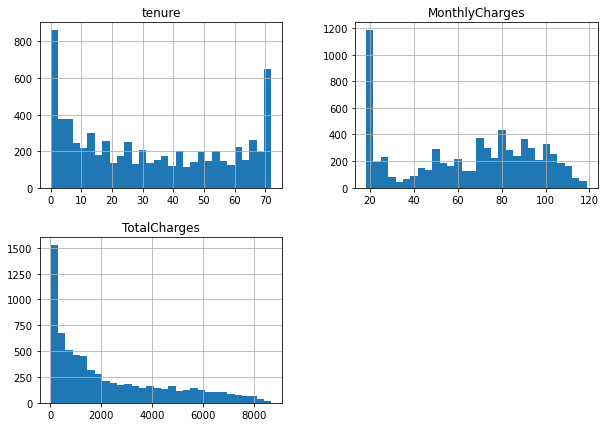

In [25]:
df[numerical_features].hist(bins=30, figsize=(10, 7))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x700000404a77908>,
      dtype=object)

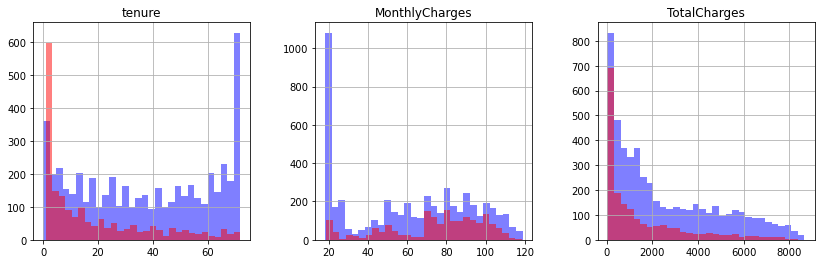

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
df[df.Churn == "No"][numerical_features].hist(bins=30, color="blue", alpha=0.5, ax=ax)
df[df.Churn == "Yes"][numerical_features].hist(bins=30, color="red", alpha=0.5, ax=ax)

#### Categorical feature distribution

To analyze categorical features, we use bar charts. We observe that Senior citizens and customers without phone service are less represented in the data.

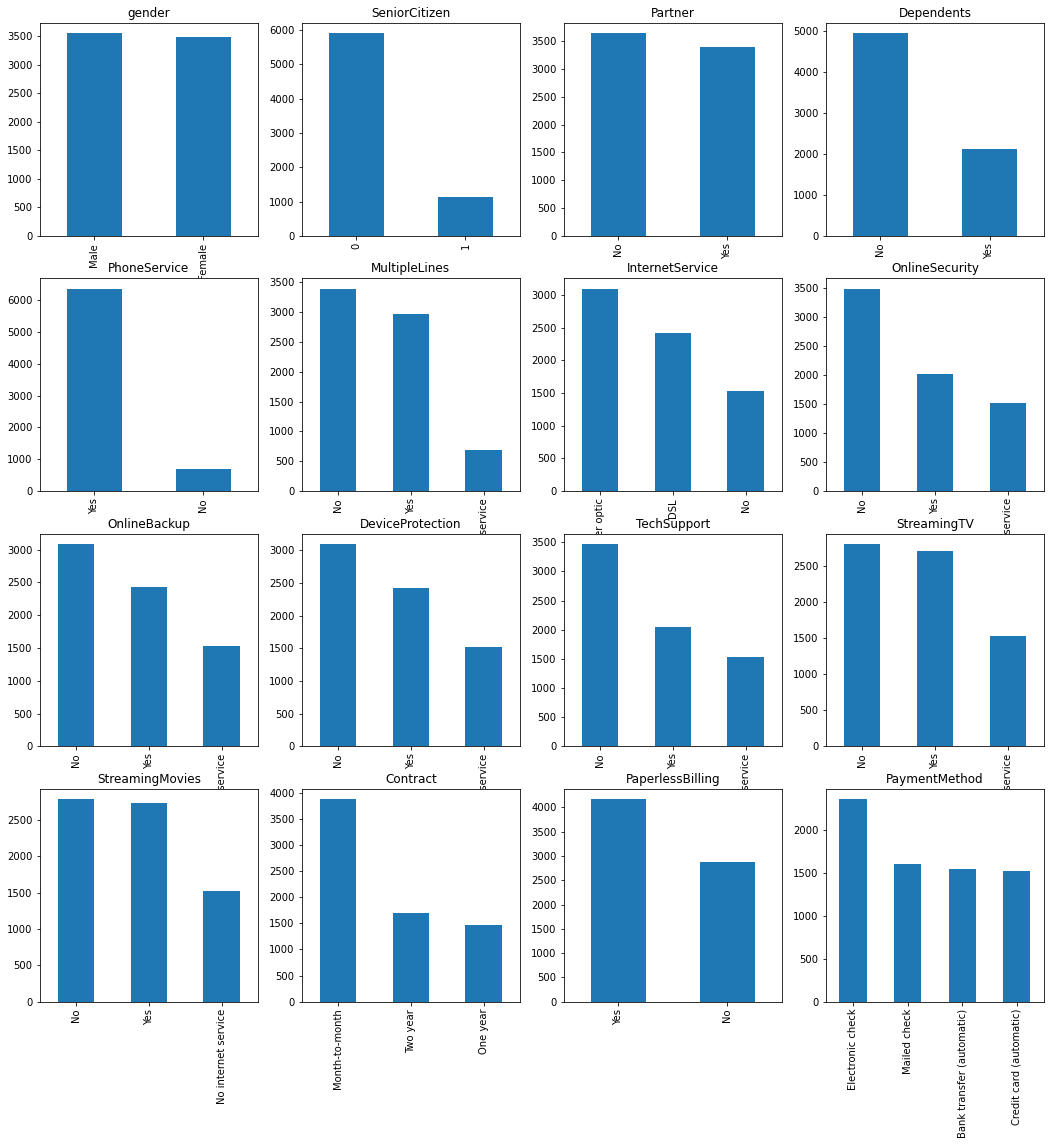

In [28]:
ROWS, COLS = 4, 4
fig, ax = plt.subplots(ROWS, COLS, figsize=(18, 18))
row, col = 0, 0
for i, categorical_feature in enumerate(categorical_features):
    if col == COLS - 1:
        row += 1
    col = i % COLS
    df[categorical_feature].value_counts().plot(kind='bar', ax=ax[row, col]).set_title(categorical_feature)

Text(0.5, 1.0, 'churned')

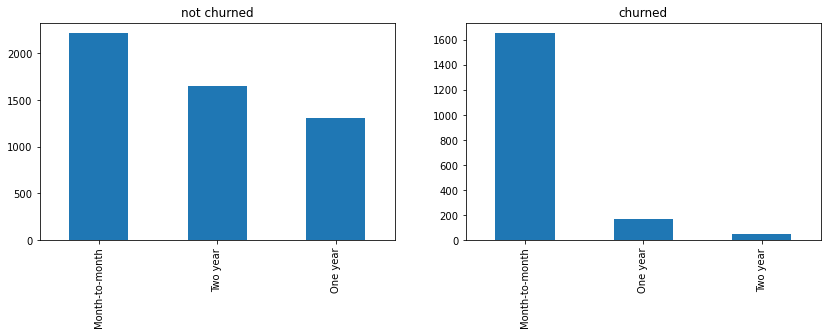

In [30]:
feature = 'Contract'
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
df[df.Churn == "No"][feature].value_counts().plot(kind='bar', ax=ax[0]).set_title('not churned')
df[df.Churn == "Yes"][feature].value_counts().plot(kind='bar', ax=ax[1]).set_title('churned')

#### Target variable distribution
Target variable distribution shows that we are dealing with an imbalanced problem as there are many more non-churned as churned users. The model would achieve high accuracy as it would mostly predict majority class - users who didn't churn in our example.

Text(0.5, 1.0, 'churned')

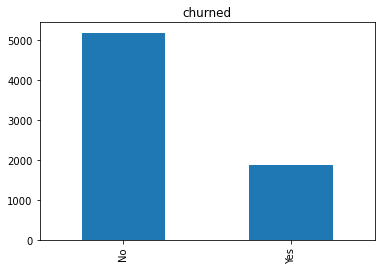

In [32]:
df[target].value_counts().plot(kind='bar').set_title('churned')

### Plot Relationships

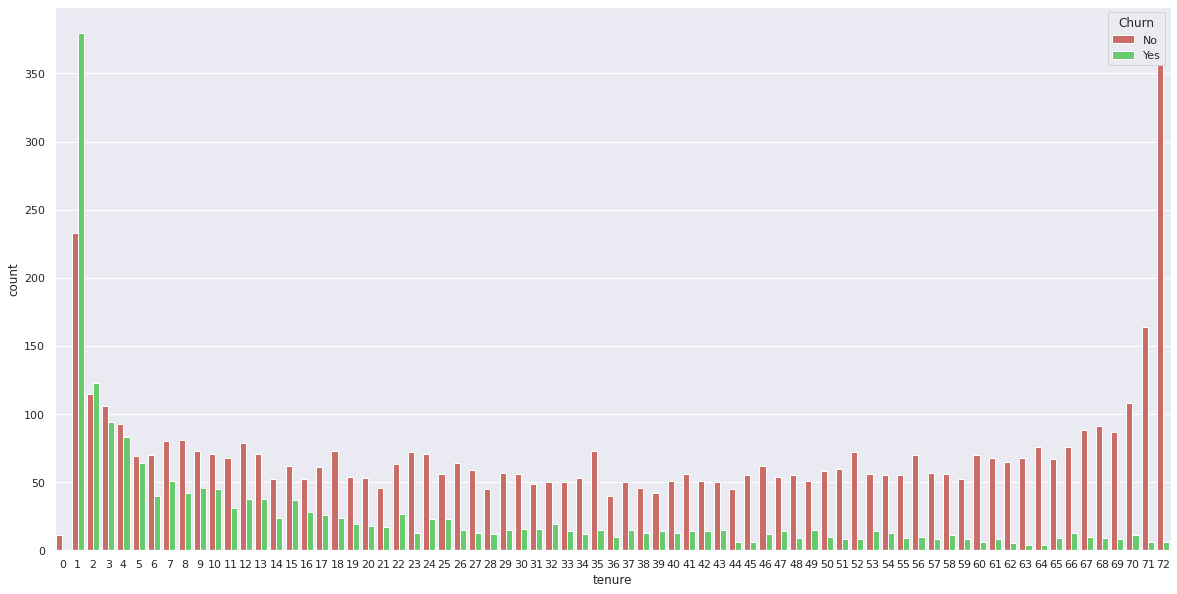

In [33]:
# Plot Tenure Frequency count
sns.set(style="darkgrid")
sns.set_palette("hls", 3)
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.countplot(x="tenure", hue="Churn", data=customer_data)

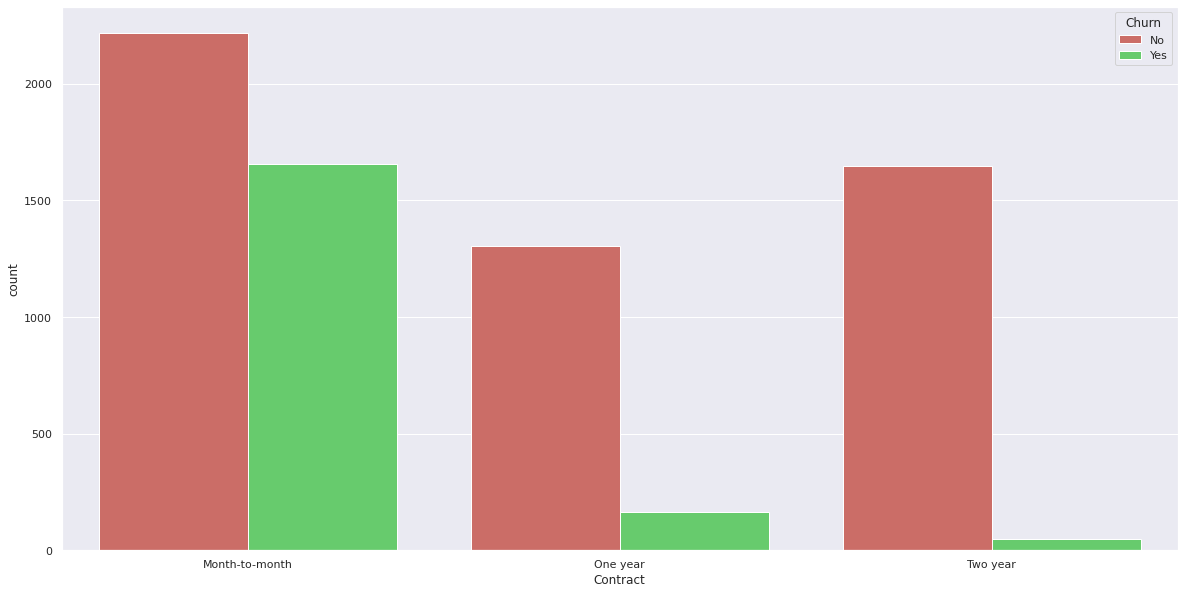

In [34]:
#Contract
sns.set(style="darkgrid")
sns.set_palette("hls", 3)
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.countplot(x="Contract", hue="Churn", data=customer_data)

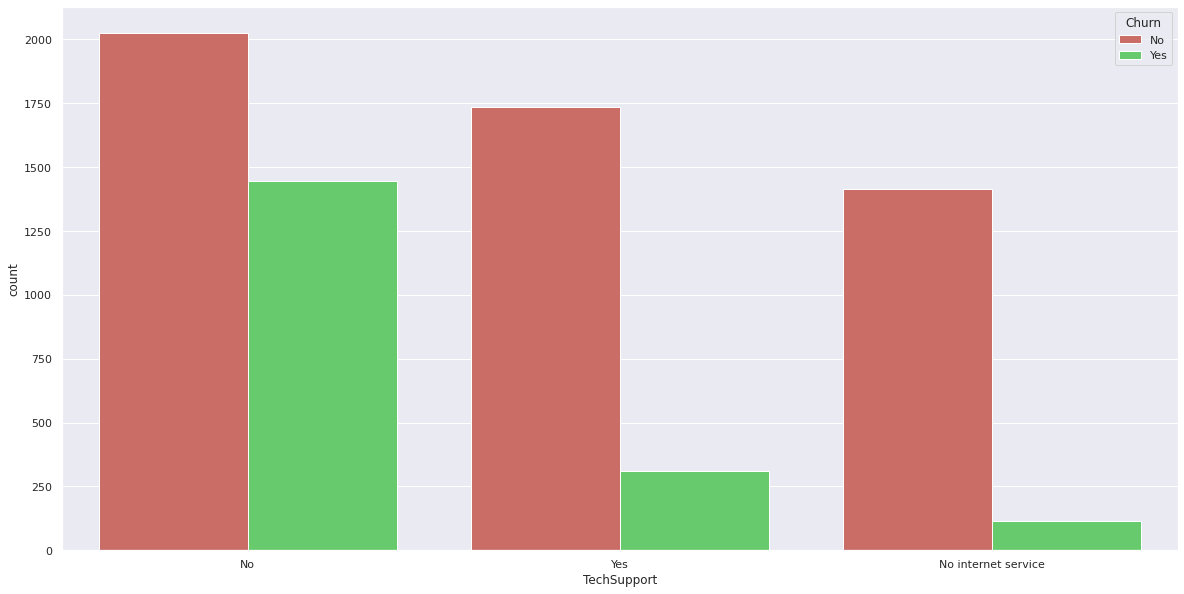

In [35]:
# Plot TechSupport Frequency count
sns.set(style="darkgrid")
sns.set_palette("hls", 3)
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.countplot(x="TechSupport", hue="Churn", data=customer_data)


In [26]:
# Create Grid for pairwise relationships
# allows us to see both distribution of single variables and relationships between two variables.
##gr = sns.PairGrid(customer_data, height=5, hue="Churn")
##gr = gr.map_diag(plt.hist)
##gr = gr.map_offdiag(plt.scatter)
##gr = gr.add_legend()

In [27]:
# Set up plot size
##fig, ax = plt.subplots(figsize=(6,6))

# Attributes distribution
#a = sns.boxplot(orient="v", palette="hls", data=customer_data.iloc[:, 18], fliersize=14)

In [28]:
# Tenure data distribution
##histogram = sns.distplot(customer_data.iloc[:, 4], hist=True)
##plt.show()


/QOpenSys/pkgs/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


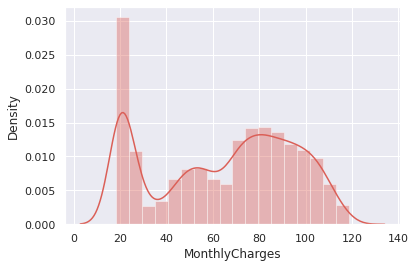

In [38]:
# Monthly Charges data distribution
histogram = sns.distplot(customer_data.iloc[:, 17], hist=True)
plt.show()

## Encoding features
To prepare the dataset for modeling churn, we need to encode categorical features to numbers. This means encoding "Yes", "No" to 0 and 1 so that algorithm can work with the data. This process is called onehot encoding.

In [39]:
from sklearn.preprocessing import LabelEncoder

pd.set_option('precision', 3)
##customer_data.describe()
##customer_data.describe(exclude=np.number)
##customer_data.corr(method='pearson')
##display(customer_data)

customer_data_encoded = pd.get_dummies(customer_data)
customer_data_encoded.head(10)

# Create training data for non-preprocessed approach
X_npp = customer_data.iloc[:, :-1].apply(LabelEncoder().fit_transform)
pd.DataFrame(X_npp).head(5)

# Create training data for that will undergo preprocessing
X = customer_data_encoded.iloc[:, :-2]
X.head(5)

# Extract labels
y_unenc = customer_data['Churn']

# Convert strings of 'yes' and 'no' to binary values of 0 or 1
le = LabelEncoder()
le.fit(y_unenc)

y_le = le.transform(y_unenc)
pd.DataFrame(y_le).head(5)



,0
0,0
1,0
2,1
3,0
4,1


## Outlier Detection
Anomalies, wrong data in the dataset?

In [40]:
# Calculate the Z-score using median value and median absolute deviation for more robust calculations
# Working on Monthly Charges column
threshold = 3

median = np.median(X['MonthlyCharges'])
median_absolute_deviation = np.median([np.abs(x - median) for x in X['MonthlyCharges']])
modified_z_scores = [0.6745 * (x - median) / median_absolute_deviation
                         for x in X['MonthlyCharges']]
results = np.abs(modified_z_scores) > threshold

print(np.any(results))

False


In [41]:
# Do the same for Total Charges column but using the interquartile method

quartile_1, quartile_3 = np.percentile(X['TotalCharges'], [25, 75])
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)

print(np.where((X['TotalCharges'] > upper_bound) | (X['TotalCharges'] < lower_bound)))


(array([], dtype=int64),)


## Feature Engineering

In [42]:
from sklearn.preprocessing import PolynomialFeatures
import sklearn.feature_selection

# Find interactions between current features and append them to the dataframe
def add_interactions(dataset):
    # Get feature names
    comb = list(combinations(list(dataset.columns), 2))
    col_names = list(dataset.columns) + ['_'.join(x) for x in comb]
    
    # Find interactions
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    dataset = poly.fit_transform(dataset)
    dataset = pd.DataFrame(dataset)
    dataset.columns = col_names
    
    # Remove interactions with 0 values
    no_inter_indexes = [i for i, x in enumerate(list((dataset ==0).all())) if x]
    dataset = dataset.drop(dataset.columns[no_inter_indexes], axis=1)
    
    return dataset


X_inter = add_interactions(X)
X_inter.head(15)

# Select best features
select = sklearn.feature_selection.SelectKBest(k=25)
selected_features = select.fit(X_inter, y_le)
indexes = selected_features.get_support(indices=True)
col_names_selected = [X_inter.columns[i] for i in indexes]

X_selected = X_inter[col_names_selected]
X_selected.head(10)

,tenure,OnlineSecurity_No,TechSupport_No,Contract_Month-to-month,MonthlyCharges_OnlineSecurity_No,MonthlyCharges_TechSupport_No,MonthlyCharges_Contract_Month-to-month,Dependents_No_OnlineSecurity_No,Dependents_No_TechSupport_No,Dependents_No_Contract_Month-to-month,PhoneService_Yes_Contract_Month-to-month,InternetService_Fiber optic_OnlineSecurity_No,InternetService_Fiber optic_TechSupport_No,InternetService_Fiber optic_Contract_Month-to-month,InternetService_Fiber optic_PaymentMethod_Electronic check,OnlineSecurity_No_OnlineBackup_No,OnlineSecurity_No_TechSupport_No,OnlineSecurity_No_Contract_Month-to-month,OnlineSecurity_No_PaymentMethod_Electronic check,OnlineBackup_No_Contract_Month-to-month,DeviceProtection_No_Contract_Month-to-month,TechSupport_No_Contract_Month-to-month,TechSupport_No_PaymentMethod_Electronic check,Contract_Month-to-month_PaperlessBilling_Yes,Contract_Month-to-month_PaymentMethod_Electronic check
0,1.0,1.0,1.0,1.0,29.85,29.85,29.85,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
1,34.0,0.0,1.0,0.0,0.00,56.95,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,1.0,1.0,0.00,53.85,53.85,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,45.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,1.0,1.0,1.0,70.70,70.70,70.70,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,8.0,1.0,1.0,1.0,99.65,99.65,99.65,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
6,22.0,1.0,1.0,1.0,89.10,89.10,89.10,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
7,10.0,0.0,1.0,1.0,0.00,29.75,29.75,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
8,28.0,1.0,0.0,1.0,104.80,0.00,104.80,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
9,62.0,0.0,1.0,0.0,0.00,56.15,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Split (Training / Test) and Normalization (x = (x - xmin) / (xmax - xmin) ) 

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  StandardScaler

#Split Data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_le,\
                                                    test_size=0.33, random_state=42)
print("training size: ", X_train.shape, y_train.shape)
print("test size",  X_test.shape, y_test.shape)

# Use StandardScaler
scaler = StandardScaler().fit(X_train, y_train)
X_train_scaled = scaler.transform(X_train)

pd.DataFrame(X_train_scaled, columns=X_train.columns).head()
pd.DataFrame(y_train).head(5)

training size:  (4718, 25) (4718,)
test size (2325, 25) (2325,)


,0
0,0
1,1
2,0
3,1
4,0


## Building a Classifier 
### SVM (Support Vector Machine algorithm) - scikit learn SVC 

In [44]:

#Support Vector Macines on preprocessed data
from sklearn.svm import SVC
# Run classifier
clf_svc = SVC(random_state=42, probability=True)
clf_svc.fit(X_train_scaled, y_train)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

### Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression()
model = clf_lr.fit(X_train_scaled, y_train)
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Multilayer Perceptron (Neural Network) 

In [46]:
from sklearn.neural_network import MLPClassifier

clf_mlp = MLPClassifier(verbose=0)
clf_mlp.fit(X_train_scaled, y_train)

# Note: MLP as a NN, can use data without the feature engineering step, as the NN will handle that automatically

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=0, warm_start=False)

## Model Evaluation
### SVC

In [47]:
from sklearn.metrics import average_precision_score

# Use the scaler fit on trained data to scale our test data
X_test_scaled = scaler.transform(X_test)
pd.DataFrame(X_test_scaled, columns=X_train.columns).head()

# Get accuracy score
from sklearn.metrics import accuracy_score
# Get model confidence of predictions
y_score_svc = clf_svc.decision_function(X_test_scaled)
y_score_svc

# Get Precision vs. Recall score

# Get accuracy score
y_pred_svc = clf_svc.predict(X_test_scaled)
acc_svc = accuracy_score(y_test, y_pred_svc)
print("Accuracy:", acc_svc)

# Get Precision vs. Recall score
average_precision_svc = average_precision_score(y_test, y_score_svc)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_svc))

### Recall or true positive rate/sensitivity  
### Recall    = tp / tp + fn
### Precision = tp / tp + fp 

Accuracy: 0.8008602150537635
Average precision-recall score: 0.65


### MLP

In [48]:
y_score_mlp = clf_mlp.predict_proba(X_test_scaled)[:, 1]
y_score_mlp
y_pred_mlp = clf_mlp.predict(X_test_scaled)
acc_mlp = accuracy_score(y_test, y_pred_mlp)
print("Accuracy:", acc_mlp)
average_precision_mlp = average_precision_score(y_test, y_score_mlp)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_mlp))

Accuracy: 0.8086021505376344
Average precision-recall score: 0.68


### Logistic Regression

In [49]:
y_score_lr = clf_lr.decision_function(X_test_scaled)
y_score_lr
y_pred_lr = clf_lr.predict(X_test_scaled)
acc_lr = accuracy_score(y_test, y_pred_lr)
print("Accuracy:", acc_lr)
average_precision_lr = average_precision_score(y_test, y_score_lr)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_lr))  

Accuracy: 0.8098924731182796
Average precision-recall score: 0.67


## Model Comparison & Selection

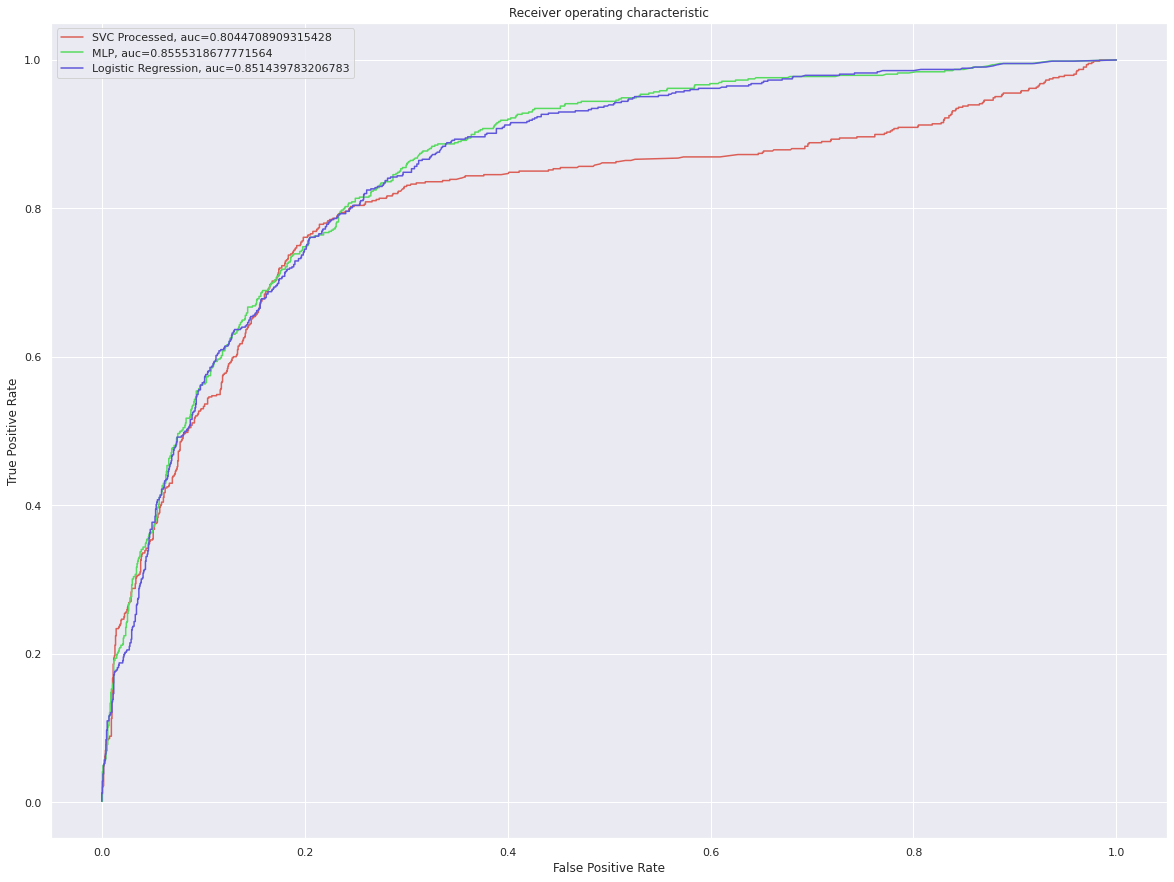

In [50]:
import sklearn.metrics as metrics
## Model Comparison - ROC Curves 
plt.figure(0, figsize=(20,15)).clf()

fpr_svc, tpr_svc, thresh_svc = metrics.roc_curve(y_test, y_score_svc)
auc_svc = metrics.roc_auc_score(y_test, y_score_svc)
plt.plot(fpr_svc, tpr_svc, label="SVC Processed, auc=" + str(auc_svc))

fpr_mlp, tpr_mlp, thresh_mlp = metrics.roc_curve(y_test, y_score_mlp)
auc_mlp = metrics.roc_auc_score(y_test, y_score_mlp)
plt.plot(fpr_mlp, tpr_mlp, label="MLP, auc=" + str(auc_mlp))

fpr_lr, tpr_lr, thresh_lr = metrics.roc_curve(y_test, y_score_lr)
auc_lr = metrics.roc_auc_score(y_test, y_score_lr)
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression, auc=" + str(auc_lr))

#plt.legend(loc=0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="upper left")

In [51]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_svc))

             precision    recall  f1-score   support

          0       0.84      0.90      0.87      1697
          1       0.66      0.54      0.60       628

avg / total       0.79      0.80      0.79      2325



## Test / Inference

In [52]:
XInfer= np.array([[20.0, 0.0, 1.0, 0.0, 60.55, 10.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
print("Support Vector Machine (aka Scikit Learn SVC) Model Inference - Telco Churn on IBM i 7.3")
print("Input Data to classify:\n", end="")
print(XInfer)
print("Result (Class):", end="")
print(clf_svc.predict(XInfer))
print("Result (Probability):", end="")
print(clf_svc.predict_proba(XInfer))


Support Vector Machine (aka Scikit Learn SVC) Model Inference - Telco Churn on IBM i 7.3
Input Data to classify:
[[20.    0.    1.    0.   60.55 10.   15.    0.    0.    0.    0.    0.
   1.    1.    1.    1.    0.    0.    0.    0.    0.    0.    0.    0.
   0.  ]]
Result (Class):[0]
Result (Probability):[[0.75022296 0.24977704]]


## Model Persistence  
### Save trained model to IFS

In [53]:

from joblib import dump, load
dump(clf_svc, './SVC_Model_CHURN_IBMi_V1.joblib') 


['./SVC_Model_CHURN_IBMi_V1.joblib']

In [54]:
## Let'store the Columns / Features list 
model_columns = list(X_selected.columns)
dump(model_columns,'./SVC_Columns.pkl')

['./SVC_Columns.pkl']

   ### Load trained model
   #### Python Application can use the created model

In [55]:
from joblib import load
clf_svc = load('SVC_Model_CHURN_IBMi_V1.joblib') 

# Test the Model - Model Inference on IBM i

In [56]:
#XInfer=pd.DataFrame(X_train_scaled, columns=X_train.columns).head(20).values                                                                                                              
#print(clf_svc.predict(XInfer))                                                                                                                                                            
#[0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0]

#X_train_scaled.shape                                                                                                                                                                      
#(4718, 25)

X_test_scaled.shape                                                                                                                                                                       
#(2325, 25)
print("Testing model on IBM i")
#print("Test Dataset:")
#print(X_test_scaled)

XInfer=pd.DataFrame(X_test_scaled, columns=X_train.columns).head(20).values                                                                                                               
print("IBM i Scikit Learn Scoring on 20 new Customers ")
print(clf_svc.predict(XInfer))                                                                                                                                                            
#[1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1]


Testing model on IBM i
IBM i Scikit Learn Scoring on 20 new Customers 
[1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1]


In [57]:
print(clf_svc.predict_proba(XInfer))

[[0.27807305 0.72192695]
 [0.84525602 0.15474398]
 [0.8468064  0.1531936 ]
 [0.31472176 0.68527824]
 [0.8481302  0.1518698 ]
 [0.86909208 0.13090792]
 [0.84684585 0.15315415]
 [0.84687523 0.15312477]
 [0.84688002 0.15311998]
 [0.84667508 0.15332492]
 [0.84681327 0.15318673]
 [0.79215102 0.20784898]
 [0.84859706 0.15140294]
 [0.57221692 0.42778308]
 [0.84757387 0.15242613]
 [0.30380482 0.69619518]
 [0.35427589 0.64572411]
 [0.29005994 0.70994006]
 [0.60271335 0.39728665]
 [0.35797719 0.64202281]]
